# Elliptic Curve Cryptography

Bloqs for breaking elliptic curve cryptography systems via the discrete log.

Elliptic curve cryptography is a form of public key cryptography based on the finite
field of elliptic curves. For our purposes, we will denote the group operation as addition
(whose definition we will explore later) $A + B$. We will denote repeated addition
 as $[k] A = A + \dots + A$ ($k$ times).

Within this algebra, the cryptographic scheme relates the public and private keys via
$$
Q = [k] P
$$
for private key $k$, public key $Q$, and a choice of base point $P$. The cryptographic
security comes from the difficulty of inverting the multiplication. I.e. it is difficult
to do a discrete logarithm in this field.

Using Shor's algorithm for the discrete logarithm, we can find $k$ in polynomial time
with a quantum algorithm.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `FindECCPrivateKey`
Perform two phase estimations to break elliptic curve cryptography.

This follows the strategy in Litinski 2023. We perform two phase estimations corresponding
to `ECCAddR(R=P)` and `ECCAddR(R=Q)` for base point $P$ and public key $Q$.

The first phase estimation projects us into a random eigenstate of the ECCAddR(R=P) operator
which we index by the integer $c$. Per eq. 5 in the reference, these eigenstates take the form
$$
|\psi_c \rangle = \sum_j^{r-1} \omega^{cj}\ | [j]P \rangle  \\
\omega = e^{2\pi i / r} \\
[r] P = P
$$

This state is a simultaneous eigenstate of the second operator, `ECCAddR(R=Q)`. By
the definition of the operator, acting it upon $|\psi_c\rangle$ gives:
$$
|\psi_c \rangle \rightarrow \sum_j w^{cj} | [j]P + Q \rangle\rangle
$$

The private key $k$ that we wish to recover relates the public key to the base point
$$
Q = [k] P
$$
so our simultaneous eigenstate can be equivalently written as
$$
\sum_j^{r-1} \omega^{cj} | [j+k] P \rangle \\
= \omega^{-ck} |\psi_c \rangle
$$

Therefore, the measured result of the second phase estimation is $ck$. Since we have
already measured the random index $c$, we can divide it out to recover the private key $k$.

#### Parameters
 - `n`: The bitsize of the elliptic curve points' x and y registers.
 - `base_point`: The base point $P$ with unknown order $r$ such that $P = [r] P$.
 - `public_key`: The public key $Q$ such that $Q = [k] P$ for private key $k$. 

#### References
 - [How to compute a 256-bit elliptic curve private key with only 50 million Toffoli gates](https://arxiv.org/abs/2306.08585). Litinski. 2023. Figure 4 (a).


In [2]:
from qualtran.bloqs.factoring.ecc import FindECCPrivateKey

In [3]:
from qualtran.bloqs.factoring.ecc import ECPoint

### Example Instances

In [4]:
n, p = sympy.symbols('n p')
Px, Py, Qx, Qy = sympy.symbols('P_x P_y Q_x Q_y')
P = ECPoint(Px, Py, mod=p)
Q = ECPoint(Qx, Qy, mod=p)
ecc = FindECCPrivateKey(n=n, base_point=P, public_key=Q)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([ecc],
           ['`ecc`'])

### Call Graph

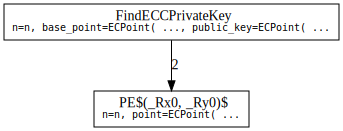

#### Counts totals:
 - `PE$(_Rx0, _Ry0)$`: 2

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
ecc_g, ecc_sigma = ecc.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(ecc_g)
show_counts_sigma(ecc_sigma)

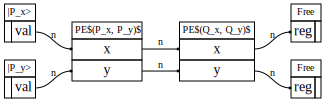

In [7]:
show_bloq(ecc.decompose_bloq())

## `ECPhaseEstimateR`
Perform a single phase estimation of ECAddR for a given point.

This is used as a subroutine in `FindECCPrivateKey`. First, we phase-estimate the
addition of the base point $P$, then of the public key $Q$.

#### Parameters
 - `n`: The bitsize of the elliptic curve points' x and y registers.
 - `point`: The elliptic curve point to phase estimate against.


In [8]:
from qualtran.bloqs.factoring.ecc import ECPhaseEstimateR

### Example Instances

In [9]:
n, p = sympy.symbols('n p ')
Rx, Ry = sympy.symbols('R_x R_y')
ec_pe = ECPhaseEstimateR(n=n, point=ECPoint(Rx, Ry, mod=p))

#### Graphical Signature

In [10]:
from qualtran.drawing import show_bloqs
show_bloqs([ec_pe],
           ['`ec_pe`'])

### Call Graph

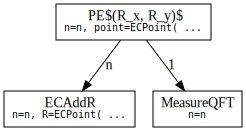

#### Counts totals:
 - `ECAddR`: $\displaystyle n$
 - `MeasureQFT`: 1

In [11]:
from qualtran.resource_counting.generalizers import ignore_split_join
ec_pe_g, ec_pe_sigma = ec_pe.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(ec_pe_g)
show_counts_sigma(ec_pe_sigma)

## `ECAddR`
Perform elliptic curve addition of constant `R`.

Given the constant elliptic curve point $R$ and an input point $A$
factored into the `x` and `y` registers such that $|A\rangle = |(a_x,a_y)\rangle$,
this bloq takes

$$
|A\rangle \rightarrow |A+R\rangle
$$

#### Parameters
 - `n`: The bitsize of the two registers storing the elliptic curve point.
 - `R`: The elliptic curve point to add. 

#### Registers
 - `ctrl`: A control bit.
 - `x`: The x component of the input elliptic curve point of bitsize `n`.
 - `y`: The y component of the input elliptic curve point of bitsize `n`. 

#### References
 - [How to compute a 256-bit elliptic curve private key with only 50 million Toffoli gates](https://arxiv.org/abs/2306.08585). Litinski. 2023. Section 1, eq. (3) and (4).
 - [Quantum resource estimates for computing elliptic curve discrete logarithms](https://arxiv.org/abs/1706.06752). Roetteler et. al. 2017. Algorithm 1 and Figure 10.
 - [https://github.com/microsoft/QuantumEllipticCurves/blob/dbf4836afaf7a9fab813cbc0970e65af85a6f93a/MicrosoftQuantumCrypto/EllipticCurves.qs#L456](QuantumQuantumCrypto). `DistinctEllipticCurveClassicalPointAddition`.


In [12]:
from qualtran.bloqs.factoring.ecc import ECAddR

### Example Instances

In [13]:
n, p, Rx, Ry = sympy.symbols('n p R_x R_y')
ec_add_r = ECAddR(n=n, R=ECPoint(Rx, Ry, mod=p))

In [14]:
n = 5  # fits our mod = 17
P = ECPoint(15, 13, mod=17, curve_a=0)
ec_add_r_small = ECAddR(n=n, R=P)

#### Graphical Signature

In [15]:
from qualtran.drawing import show_bloqs
show_bloqs([ec_add_r, ec_add_r_small],
           ['`ec_add_r`', '`ec_add_r_small`'])

### Call Graph

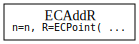

#### Counts totals:
 - `ECAddR`: 1

In [16]:
from qualtran.resource_counting.generalizers import ignore_split_join
ec_add_r_g, ec_add_r_sigma = ec_add_r.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(ec_add_r_g)
show_counts_sigma(ec_add_r_sigma)

In [17]:
for j in range(1, 20+1):
    bloq = ECAddR(n=5, R=j*P)
    ctrl, x, y = bloq.call_classically(ctrl=1, x=P.x, y=P.y)
    print(f'+[{j:2d}] P  ->  ({x:2d}, {y:2d})')

+[ 1] P  ->  ( 2, 10)
+[ 2] P  ->  ( 8,  3)
+[ 3] P  ->  (12,  1)
+[ 4] P  ->  ( 6,  6)
+[ 5] P  ->  ( 5,  8)
+[ 6] P  ->  (10, 15)
+[ 7] P  ->  ( 1, 12)
+[ 8] P  ->  ( 3,  0)
+[ 9] P  ->  ( 1,  5)
+[10] P  ->  (10,  2)
+[11] P  ->  ( 5,  9)
+[12] P  ->  ( 6, 11)
+[13] P  ->  (12, 16)
+[14] P  ->  ( 8, 14)
+[15] P  ->  ( 2,  7)
+[16] P  ->  (15,  4)
+[17] P  ->  ( 0,  0)
+[18] P  ->  (15, 13)
+[19] P  ->  ( 2, 10)
+[20] P  ->  ( 8,  3)


## `ECWindowAddR`
Perform elliptic curve addition of many multiples of constant `R`.

This adds R, 2R, ... 2^window_size into the register.

#### Parameters
 - `n`: The bitsize of the two registers storing the elliptic curve point
 - `window_size`: The number of bits in the window.
 - `R`: The elliptic curve point to add. 

#### Registers
 - `ctrl`: `window_size` control bits.
 - `x`: The x component of the input elliptic curve point of bitsize `n`.
 - `y`: The y component of the input elliptic curve point of bitsize `n`. 

#### References
 - [How to compute a 256-bit elliptic curve private key with only 50 million Toffoli gates](https://arxiv.org/abs/2306.08585). Litinski. 2013. Section 1, eq. (3) and (4).


In [18]:
from qualtran.bloqs.factoring.ecc import ECWindowAddR

### Example Instances

In [19]:
n, p = sympy.symbols('n p')
Rx, Ry = sympy.symbols('Rx Ry')
ec_window_add = ECWindowAddR(n=n, window_size=3, R=ECPoint(Rx, Ry, mod=p))

#### Graphical Signature

In [20]:
from qualtran.drawing import show_bloqs
show_bloqs([ec_window_add],
           ['`ec_window_add`'])

### Call Graph

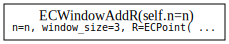

#### Counts totals:
 - `ECWindowAddR(self.n=n)`: 1

In [21]:
from qualtran.resource_counting.generalizers import ignore_split_join
ec_window_add_g, ec_window_add_sigma = ec_window_add.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(ec_window_add_g)
show_counts_sigma(ec_window_add_sigma)